#Imports & Notes:

In [4]:
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

#Task 1:

In [1]:
class MineSweeper_Bots:
    def __init__(self, rows, cols, num_of_mines, allow_mines, allow_print):
        """
        Initialize the Minesweeper Logic Bot with the given parameters.
        :param rows: Number of rows in the minesweeper board.
        :param cols: Number of columns in the minesweeper board.
        :param num_of_mines: Total number of mines to be placed on the board.
        :param allow_mines: Boolean indicating whether the game should continue after hitting a mine.
        :param allow_print: Boolean indicating whether the board should be printed after each move.
        """
        self.rows = rows
        self.cols = cols
        self.num_of_mines = num_of_mines
        self.allow_mines = allow_mines
        self.allow_print = allow_print
        self.adj_directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        self.reset()

    def reset(self):
        """
        Reset or initialize the board at the start of a new game. This method sets up the board, mines,
        and other game variables to their starting state.
        """
        self.board = [['#' for _ in range(self.cols)] for _ in range(self.rows)]
        self.cells_remaining = set((i, j) for i in range(self.rows) for j in range(self.cols))
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.clue_number = {}
        self.revealed_cells = set()
        self.mines_triggered = set()

        self.input_states = []
        self.output_states = []

        # Select the initial safe cell randomly and set it up without a mine
        r, c = random.randint(0, self.rows - 1), random.randint(0, self.cols - 1)
        self.initial_safe_cell(r, c)

    def initial_safe_cell(self, r, c):
        """
        Set up the initial safe cell and its neighbors. The selected cell and its neighbors are cleared
        of mines and marked safe.
        :param r: Row index of the initially selected safe cell.
        :param c: Column index of the initially selected safe cell.
        """
        self.board[r][c] = '0'  # Set the clue of the initial cell to 0, indicating no adjacent mines
        self.cells_remaining.remove((r, c))
        self.revealed_cells.add((r, c))
        self.clue_number[(r, c)] = 0

        valid_neighbors = self.get_neighbors((r, c))
        self.inferred_safe.update(valid_neighbors)
        for nei in valid_neighbors:
            self.cells_remaining.remove(nei)

        # Print the initial board setup if allowed
        if self.allow_print:
            self.print_board()

        # Exclude the initial safe cell and its neighbors from being potential mine locations
        possible_mine_locations = list(self.cells_remaining - self.inferred_safe)
        self.mines = set(random.sample(possible_mine_locations, self.num_of_mines))

    def get_neighbors(self, cell):
        """
        Get all valid neighboring cells of a given cell.
        :param cell: A tuple (r, c) representing the cell for which neighbors are to be found.
        :return: A set of tuples representing the valid neighbors of the given cell.
        """
        r, c = cell
        return {(r + dr, c + dc) for dr, dc in self.adj_directions if 0 <= r + dr < self.rows and 0 <= c + dc < self.cols}

    def print_board(self):
        """
        Print the current state of the minesweeper board.
        """
        for row in self.board:
            print(' '.join(str(cell) for cell in row))
        print()

    def reveal_clue(self, reveal_cell):
        valid_neighbors = self.get_neighbors(reveal_cell)
        return sum(1 for nei in valid_neighbors if nei in self.mines)

    def play(self):
        while True:
            if (self.rows*self.cols)-self.num_of_mines == len(self.revealed_cells):
                return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states

            if self.inferred_safe:
                reveal_cell = self.inferred_safe.pop()
            else:
                reveal_cell = self.cells_remaining.pop()

            if reveal_cell in self.mines:
                self.mines_triggered.add(reveal_cell)
                r_m, c_m = reveal_cell
                self.board[r_m][c_m] = 'M'
                if not self.allow_mines:
                    if self.allow_print:
                        self.print_board()
                    self.generate_data()
                    return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states
            else:
                self.revealed_cells.add(reveal_cell)
                reveal_cell_clue = self.reveal_clue(reveal_cell)
                self.clue_number[reveal_cell] = reveal_cell_clue
                r, c = reveal_cell
                self.board[r][c] = str(reveal_cell_clue)

            if self.allow_print:
                self.print_board()
            self.generate_data()

            for cell, clue in self.clue_number.items():
                valid_neighbors = self.get_neighbors(cell)
                num_nei_inferred_mines = sum(1 for nei in valid_neighbors if nei in self.inferred_mine)
                num_unrevealed_nei = sum(1 for nei in valid_neighbors if nei not in self.revealed_cells)

                if (clue - num_nei_inferred_mines) == num_unrevealed_nei:
                    for nei in valid_neighbors:
                        if nei not in self.revealed_cells:
                            self.inferred_mine.add(nei)
                            # self.cells_remaining.remove(nei)
                            self.cells_remaining.discard(nei)

                num_nei_revealed_or_inferred_safe = 0
                for nei in valid_neighbors:
                    if nei in self.revealed_cells or nei in self.inferred_safe:
                        num_nei_revealed_or_inferred_safe += 1

                if (len(valid_neighbors) - clue) - num_nei_revealed_or_inferred_safe == num_unrevealed_nei:
                    for nei in valid_neighbors:
                        if nei not in self.revealed_cells:
                            self.inferred_safe.add(nei)
                            self.cells_remaining.remove(nei)

    def generate_data(self):
        # Input: Convert self.board -> For clue #: 0 to 8, For Unclicked: 9, For Mine: 10
        # Output: Convert self.board -> For Mine: 0, For Safe: 1
        temp_i = copy.deepcopy(self.board)
        for i, row in enumerate(self.board):
            for j, element in enumerate(row):
                if element == 'M':
                    num = 10
                elif element == '#':
                    num = 9
                else:
                    num = int(element)
                temp_i[i][j] = num
        self.input_states.append(temp_i)

        temp_o = copy.deepcopy(self.board)
        for i, row in enumerate(self.board):
            for j, element in enumerate(row):
                temp_o[i][j] = 0 if (i, j) in self.mines else 1
        self.output_states.append(temp_o)

    def model_play(self, model, embeddings):
        model.eval()
        for cell in self.inferred_safe:
            self.cells_remaining.add(cell)
        while self.inferred_safe:
            self.inferred_safe.pop()

        while True:
            if (self.rows * self.cols - self.num_of_mines) == len(self.revealed_cells):
                return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states

            c_s = [[9 if cell == '#' else (10 if cell == 'M' else int(cell)) for cell in row] for row in self.board]
            current_state = torch.tensor(c_s, dtype=torch.long)
            embedded_input = embeddings(current_state).unsqueeze(0)  # Add batch dimension
            board_tensor = embedded_input.permute(0, 3, 1, 2)  # Rearrange to [batch, channels, height, width]

            # Predict the safest cell to reveal next
            with torch.no_grad():
                predictions = model(board_tensor).squeeze(0)  # Remove batch dimension

            # Choose the cell with the highest safety score
            max_prob = 0
            cell_to_reveal = None
            for r in range(self.rows):
                for c in range(self.cols):
                    if (r, c) in self.cells_remaining and predictions[r][c] > max_prob:
                        max_prob = predictions[r][c]
                        cell_to_reveal = (r, c)
            if self.allow_print:
                print(f"Clicking: {cell_to_reveal}")

            if cell_to_reveal in self.mines:
                self.mines_triggered.add(cell_to_reveal)
                r, c = cell_to_reveal
                self.board[r][c] = 'M'
                if not self.allow_mines:
                    if self.allow_print:
                        self.print_board()
                    self.generate_data()
                    return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states
            else:
                r, c = cell_to_reveal
                self.revealed_cells.add(cell_to_reveal)
                clue = self.reveal_clue(cell_to_reveal)
                self.board[r][c] = str(clue)

            self.cells_remaining.remove(cell_to_reveal)

            if self.allow_print:
                self.print_board()
            self.generate_data()

In [2]:
def run_bot_and_get_stats(rows, cols, num_of_mines, allow_mines, allow_board_print, num_game_play, flag_logic_bot, model, embeddings):
    won = 0
    cells_opened_list = []
    mines_triggered_list = []

    input_states = []
    output_states = []

    for i in range(num_game_play):
        # print(i)
        bot = MineSweeper_Bots(rows, cols, num_of_mines, allow_mines, allow_board_print)
        if flag_logic_bot:
            num_cells_opened, num_mines_triggered, i_states, o_states = bot.play()
        else:
            num_cells_opened, num_mines_triggered, i_states, o_states = bot.model_play(model, embeddings)
        if num_cells_opened == ((rows * cols) - num_of_mines) and num_mines_triggered == 0:
            won += 1
        cells_opened_list.append(num_cells_opened)
        mines_triggered_list.append(num_mines_triggered)
        input_states.extend(i_states)
        output_states.extend(o_states)

    # Calculating averages
    avg_cells_opened = np.mean(cells_opened_list)
    avg_mines_triggered = np.mean(mines_triggered_list)

    # Calculating variances
    var_cells_opened = np.var(cells_opened_list)
    var_mines_triggered = np.var(mines_triggered_list)

    print(f"Count Bot Won: {won}")
    print(f"Avg. Cells Opened: {avg_cells_opened}, Variance: {var_cells_opened}")
    print(f"Avg. Mines Triggered: {avg_mines_triggered}, Variance: {var_mines_triggered}")
    print(f"Data Points Generated: {len(input_states)}")

    return input_states, output_states, won, avg_cells_opened, avg_mines_triggered, var_cells_opened, var_mines_triggered

#Task 1: Easy Level

In [4]:
# This code approximately takes 2 mins to run on ilab2
# Easy Level - Game ends after a mine is triggered

# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
input_states_train, output_states_train, won_train, avg_cells_opened_train, avg_mines_triggered_train, var_cells_opened_train, var_mines_triggered_train = run_bot_and_get_stats(9, 9, 10, False, False, 8000, True, None, None)
print()

print("Generating Test Dataset ... ")
# Generate Test Dataset (Approx. 20%)
input_states_test, output_states_test, won_test, avg_cells_opened_test, avg_mines_triggered_test, var_cells_opened_test, var_mines_triggered_test = run_bot_and_get_stats(9, 9, 10, False, False, 2000, True, None, None)

tensor_x_train = torch.Tensor(input_states_train)
# tensor_x_train = tensor_x_train.unsqueeze(1)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
# tensor_x_test = tensor_x_test.unsqueeze(1)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Count Logic Bot Won: 239
Avg. Cell's Opened: 50.302875, Avg. Mines Triggered: 0.970125
Data Points Generated: 402184

Generating Test Dataset ... 
Count Logic Bot Won: 55
Avg. Cell's Opened: 50.105, Avg. Mines Triggered: 0.9725
Data Points Generated: 100155


In [10]:
embedding_dim = 2
num_of_embeddings = 11
embeddings = nn.Embedding(num_of_embeddings, embedding_dim)

class Minesweeper_Model_Easy(nn.Module):
    def __init__(self, embedding_dim):
        super(Minesweeper_Model_Easy, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=embedding_dim, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(9 * 9 * 256, 9 * 9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = x.reshape(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x.reshape(-1, 9, 9)

def get_output(embeddings, model, x):
    # x should be long tensor of indices with shape [batch_size, 9, 9]
    x = embeddings(x)  # Embed the input indices
    x = x.permute(0, 3, 1, 2)  # Rearrange dimensions to [batch_size, channels, height, width]
    return model(x)

In [6]:
# Initialize model
model_easy = Minesweeper_Model_Easy(embedding_dim)
print(model_easy)
print()
# Calculate and print the total number of parameters
total_params = sum(p.numel() for p in model_easy.parameters())
print("Total number of parameters: ", total_params)

# Define optimizers
model_easy_optimizer = torch.optim.SGD(model_easy.parameters(), lr=0.01)

criterion = nn.BCELoss()

Minesweeper_Model_Easy(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20736, out_features=81, bias=True)
)

Total number of parameters:  2068785


In [6]:
train_losses = []
test_losses = []

def train_and_test(model, embeddings, train_dataloader, test_dataloader, model_optimizer, criterion, epochs):
    for epoch in range(epochs):
        # Set model to training mode
        model.train()

        # Only the model parameters are trainable
        optimizer = model_optimizer

        # Training phase
        total_train_loss = 0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.long(), targets.float()  # Correct data types
            optimizer.zero_grad()
            outputs = get_output(embeddings, model, inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)  # Store train loss for plotting

        # Testing phase
        model.eval()  # Set model to evaluation mode
        total_test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs, targets = inputs.long(), targets.float()
                outputs = get_output(embeddings, model, inputs)
                loss = criterion(outputs, targets)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)  # Store test loss for plotting

        # Print average losses after each epoch
        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}')

In [8]:
# This code approximately takes 35 mins to train on ilab2
train_and_test(model_easy, embeddings, train_dataloader, test_dataloader, model_easy_optimizer, criterion, 10)

Epoch 1: Train Loss = 0.3132, Test Loss = 0.2870
Epoch 2: Train Loss = 0.2632, Test Loss = 0.2610
Epoch 3: Train Loss = 0.2423, Test Loss = 0.2476
Epoch 4: Train Loss = 0.2292, Test Loss = 0.2386
Epoch 5: Train Loss = 0.2195, Test Loss = 0.2319
Epoch 6: Train Loss = 0.2124, Test Loss = 0.2272
Epoch 7: Train Loss = 0.2071, Test Loss = 0.2241
Epoch 8: Train Loss = 0.2029, Test Loss = 0.2221
Epoch 9: Train Loss = 0.1994, Test Loss = 0.2205
Epoch 10: Train Loss = 0.1965, Test Loss = 0.2194


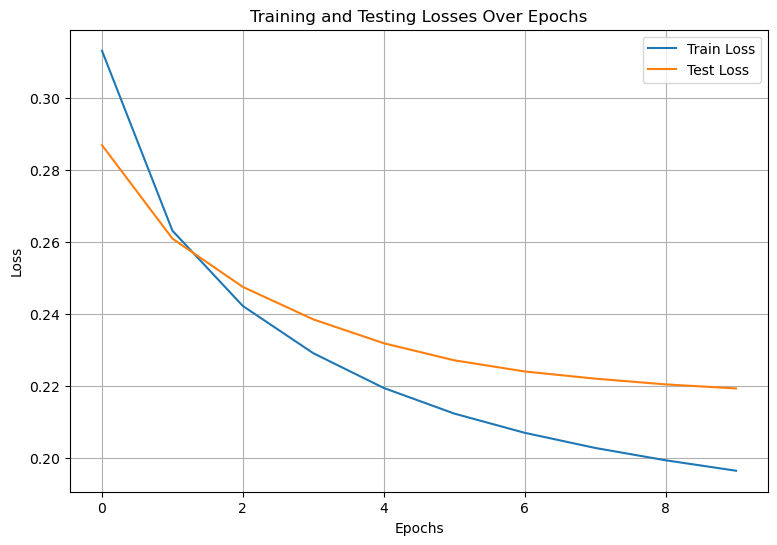

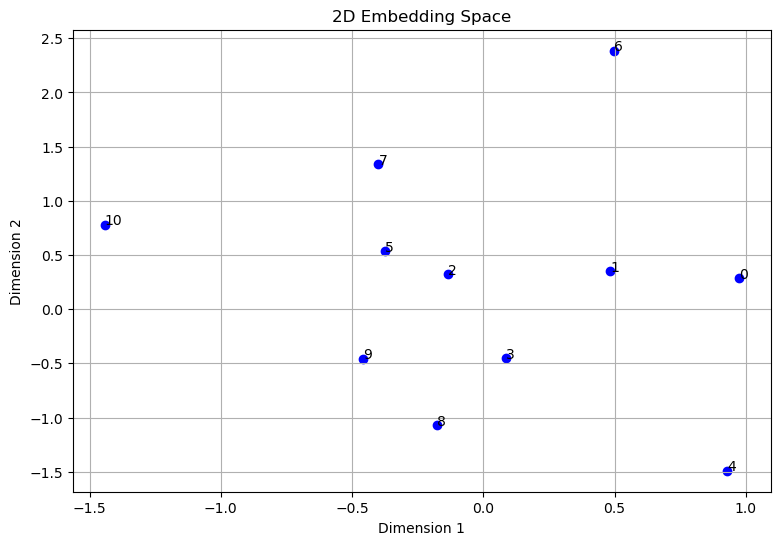

In [9]:
# Plot training and testing losses
plt.figure(figsize=(9, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot embeddings in 2D space
embed_vectors = embeddings.weight.data.cpu().numpy()
plt.figure(figsize=(9, 6))
plt.scatter(embed_vectors[:, 0], embed_vectors[:, 1], c='blue', marker='o')
for i, txt in enumerate(range(0, 11)):
    plt.annotate(txt, (embed_vectors[i, 0], embed_vectors[i, 1]))
plt.title('2D Embedding Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

In [63]:
# Save the model
torch.save(model_easy, 'model_easy.pth')

# Save the embeddings
embeddings_weights = embeddings.weight.data
torch.save(embeddings_weights, 'embeddings.pth')

In [64]:
# Load the model
model_easy = torch.load('model_easy.pth')
model_easy.eval()

# Load the embeddings
loaded_embeddings_tensor = torch.load('embeddings.pth')
num_embeddings, embedding_dim = loaded_embeddings_tensor.size(0), loaded_embeddings_tensor.size(1)
embeddings = nn.Embedding(num_embeddings, embedding_dim)
embeddings.weight.data.copy_(loaded_embeddings_tensor)
embeddings.weight.requires_grad = False

In [54]:
# This code approximately takes 2 mins to run on ilab2
# Logic Bot Performance on Easy Level - Game ends after a mine is triggered
_, _, won_e1, avg_cells_opened_e1, avg_mines_triggered_e1, var_cells_opened_e1, var_mines_triggered_e1 = run_bot_and_get_stats(9, 9, 10, False, False, 8000, True, None, None)

Count Bot Won: 255
Avg. Cells Opened: 49.960875, Variance: 227.842344234375
Avg. Mines Triggered: 0.968125, Variance: 0.030858984375
Data Points Generated: 399432


In [55]:
# This code approximately takes 18 mins to run on ilab2
# Model Performance on Easy Level - Game ends after a mine is triggered
_, _, won_e2, avg_cells_opened_e2, avg_mines_triggered_e2, var_cells_opened_e2, var_mines_triggered_e2 = run_bot_and_get_stats(9, 9, 10, False, False, 8000, False, model_easy, embeddings)

Count Bot Won: 1696
Avg. Cells Opened: 61.26825, Variance: 198.52629193750002
Avg. Mines Triggered: 0.788, Variance: 0.16705600000000004
Data Points Generated: 488450


In [67]:
# This code approximately takes 3 mins to run on ilab2
# Logic Bot Performance on Easy Level - Game ends only after all safe cells have been discovered, allowed to continue afte a mine is triggered
_, _, won_e3, avg_cells_opened_e3, avg_mines_triggered_e3, var_cells_opened_e3, var_mines_triggered_e3 = run_bot_and_get_stats(9, 9, 10, True, False, 8000, True, None, None)

Count Bot Won: 255
Avg. Cells Opened: 71.0, Variance: 0.0
Avg. Mines Triggered: 3.030625, Variance: 2.220437109375
Data Points Generated: 584245


In [68]:
# This code approximately takes 17 mins to run on ilab2
# Model Performance on Easy Level - Game ends only after all safe cells have been discovered, allowed to continue afte a mine is triggered
_, _, won_e4, avg_cells_opened_e4, avg_mines_triggered_e4, var_cells_opened_e4, var_mines_triggered_e4 = run_bot_and_get_stats(9, 9, 10, True, False, 8000, False, model_easy, embeddings)

Count Bot Won: 1678
Avg. Cells Opened: 71.0, Variance: 0.0
Avg. Mines Triggered: 2.795375, Variance: 6.748003609375001
Data Points Generated: 582363


#Task 1: Intermediate Level

In [124]:
# This code approximately takes 5 mins to run on ilab2
# Intermediate Level - Game ends after a mine is triggered

# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
input_states_train, output_states_train, won_train, avg_cells_opened_train, avg_mines_triggered_train, var_cells_opened_train, var_mines_triggered_train = run_bot_and_get_stats(16, 16, 40, False, False, 4000, True, None, None)
print()

print("Generating Test Dataset ... ")
# Generate Test Dataset (Approx. 20%)
input_states_test, output_states_test, won_test, avg_cells_opened_test, avg_mines_triggered_test, var_cells_opened_test, var_mines_triggered_test = run_bot_and_get_stats(16, 16, 40, False, False, 1000, True, None, None)

tensor_x_train = torch.Tensor(input_states_train)
# tensor_x_train = tensor_x_train.unsqueeze(1)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
# tensor_x_test = tensor_x_test.unsqueeze(1)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Count Bot Won: 0
Avg. Cells Opened: 79.9425, Variance: 1674.67819375
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 319770

Generating Test Dataset ... 
Count Bot Won: 0
Avg. Cells Opened: 80.077, Variance: 1675.889071
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 80077


In [135]:
class Minesweeper_Model_Intermediate(nn.Module):
    def __init__(self):
        super(Minesweeper_Model_Intermediate, self).__init__()
        self.conv1 = nn.Conv2d(embedding_dim, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        # Updated linear layer to handle the unchanged dimensions from the absence of pooling
        self.fc1 = nn.Linear(512 * 16 * 16, 16 * 16)  # No dimension reduction from pooling

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        # Flatten the output from the conv layers to pass through the fully connected layers
        x = x.reshape(-1, 512 * 16 * 16)  # Keep dimensions as 256 filters and 16x16 due to no pooling
        x = torch.sigmoid(self.fc1(x))
        return x.view(-1, 16, 16)  # Reshape back to the board size for output

In [136]:
# Instantiate and use the model
model_intermediate = Minesweeper_Model_Intermediate()
print(model_intermediate)
print()

# Print the total number of parameters
total_params = sum(p.numel() for p in model_intermediate.parameters())
print("Total number of parameters: ", total_params)

train_losses = []
test_losses = []

# Define optimizers
model_intermediate_optimizer = torch.optim.SGD(model_intermediate.parameters(), lr=0.01)

# Loss Function
criterion = nn.BCELoss()

Minesweeper_Model_Intermediate(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
)

Total number of parameters:  35124960


In [160]:
# This code approximately takes 40 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 3)

Epoch 1: Train Loss = 0.3888, Test Loss = 0.4028
Epoch 2: Train Loss = 0.3327, Test Loss = 0.3950
Epoch 3: Train Loss = 0.2977, Test Loss = 0.3933
Epoch 4: Train Loss = 0.2726, Test Loss = 0.3939


In [164]:
# Model Performance on Intermediate Level - Game ends after a mine is triggered
def generate_intermediate_model_data(num_train=4000, num_test=1000):
    input_states_train, output_states_train, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, num_train, False, model_intermediate, embeddings)
    print()
    input_states_test, output_states_test, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, num_test, False, model_intermediate, embeddings)

    tensor_x_train = torch.Tensor(input_states_train)
    tensor_y_train = torch.Tensor(output_states_train)
    train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    tensor_x_test = torch.Tensor(input_states_test)
    tensor_y_test = torch.Tensor(output_states_test)
    test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    return train_dataloader, test_dataloader

In [140]:
# This code approximately takes 31 mins to run on ilab2
train_dataloader, test_dataloader = generate_intermediate_model_data(4000, 1000)

Count Bot Won: 0
Avg. Cells Opened: 27.43175, Variance: 212.15584193749999
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 109727

Count Bot Won: 0
Avg. Cells Opened: 26.983, Variance: 188.26071100000001
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 26983


In [141]:
# This code approximately takes 21 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 3)

Epoch 1: Train Loss = 0.4089, Test Loss = 0.4226
Epoch 2: Train Loss = 0.3819, Test Loss = 0.4235
Epoch 3: Train Loss = 0.3625, Test Loss = 0.4250


In [142]:
# This code approximately takes 40 mins to run on ilab2
train_dataloader, test_dataloader = generate_intermediate_model_data(4000, 1000)

Count Bot Won: 0
Avg. Cells Opened: 37.13475, Variance: 386.16559243750004
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 148539

Count Bot Won: 0
Avg. Cells Opened: 37.285, Variance: 402.09377500000005
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 37285


In [143]:
# This code approximately takes 28 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 3)

Epoch 1: Train Loss = 0.3894, Test Loss = 0.4094
Epoch 2: Train Loss = 0.3572, Test Loss = 0.4103
Epoch 3: Train Loss = 0.3349, Test Loss = 0.4128


In [144]:
# This code approximately takes 50 mins to run on ilab2
train_dataloader, test_dataloader = generate_intermediate_model_data(4000, 1000)

Count Bot Won: 0
Avg. Cells Opened: 46.19175, Variance: 603.2414819375
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 184767

Count Bot Won: 0
Avg. Cells Opened: 47.497, Variance: 625.047991
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 47497


In [145]:
# This code approximately takes 36 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 3)

Epoch 1: Train Loss = 0.3714, Test Loss = 0.3962
Epoch 2: Train Loss = 0.3343, Test Loss = 0.3986
Epoch 3: Train Loss = 0.3111, Test Loss = 0.4025


In [146]:
# This code approximately takes 57 mins to run on ilab2
train_dataloader, test_dataloader = generate_intermediate_model_data(4000, 1000)

Count Bot Won: 0
Avg. Cells Opened: 54.64825, Variance: 827.3125219375
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 218593

Count Bot Won: 0
Avg. Cells Opened: 54.636, Variance: 821.5615040000001
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 54636


In [147]:
# This code approximately takes 40 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 3)

Epoch 1: Train Loss = 0.3572, Test Loss = 0.3866
Epoch 2: Train Loss = 0.3176, Test Loss = 0.3899
Epoch 3: Train Loss = 0.2936, Test Loss = 0.3921


In [148]:
# This code approximately takes 34 mins to run on ilab2
train_dataloader, test_dataloader = generate_intermediate_model_data(2000, 500)

Count Bot Won: 0
Avg. Cells Opened: 61.666, Variance: 1024.648444
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 123332

Count Bot Won: 0
Avg. Cells Opened: 62.688, Variance: 1022.6986559999999
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 31344


In [149]:
# This code approximately takes 8 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 1)

Epoch 1: Train Loss = 0.3452, Test Loss = 0.3825


In [150]:
# This code approximately takes 39 mins to run on ilab2
train_dataloader, test_dataloader = generate_intermediate_model_data(2000, 500)

Count Bot Won: 0
Avg. Cells Opened: 66.5715, Variance: 1202.33288775
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 133143

Count Bot Won: 0
Avg. Cells Opened: 66.864, Variance: 1193.4655040000002
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 33432


In [151]:
# This code approximately takes 9 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 1)

Epoch 1: Train Loss = 0.3363, Test Loss = 0.3743


In [152]:
# This code approximately takes 41 mins to run on ilab2
train_dataloader, test_dataloader = generate_intermediate_model_data(2000, 500)

Count Bot Won: 0
Avg. Cells Opened: 73.4475, Variance: 1431.73124375
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 146895

Count Bot Won: 0
Avg. Cells Opened: 67.136, Variance: 1228.4975040000002
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 33568


In [153]:
# This code approximately takes 10 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 1)

Epoch 1: Train Loss = 0.3255, Test Loss = 0.3717


In [154]:
# This code approximately takes 42 mins to run on ilab2
train_dataloader, test_dataloader = generate_intermediate_model_data(2000, 500)

Count Bot Won: 0
Avg. Cells Opened: 77.03, Variance: 1529.2331
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 154060

Count Bot Won: 0
Avg. Cells Opened: 77.944, Variance: 1661.812864
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 38972


In [156]:
# This code approximately takes 10 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 1)

Epoch 1: Train Loss = 0.3203, Test Loss = 0.3589


In [157]:
# This code approximately takes 44 mins to run on ilab2
train_dataloader, test_dataloader = generate_intermediate_model_data(2000, 500)

Count Bot Won: 0
Avg. Cells Opened: 80.0295, Variance: 1585.01062975
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 160059

Count Bot Won: 0
Avg. Cells Opened: 82.756, Variance: 1506.572464
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 41378


In [ ]:
# Save the model
torch.save(model_intermediate, 'model_intermediate.pth')

In [162]:
# This code approximately takes 11 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 1)

Epoch 1: Train Loss = 0.3157, Test Loss = 0.3568


In [165]:
# This code approximately takes 43 mins to run on ilab2
train_dataloader, test_dataloader = generate_intermediate_model_data(2000, 500)

Count Bot Won: 0
Avg. Cells Opened: 81.5845, Variance: 1721.04485975
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 163169

Count Bot Won: 0
Avg. Cells Opened: 84.372, Variance: 1727.8736159999999
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 42186


In [166]:
# This code approximately takes 27 mins to run on ilab2
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 1)

Epoch 1: Train Loss = 0.3124, Test Loss = 0.3522


In [167]:
train_dataloader, test_dataloader = generate_intermediate_model_data(2000, 500)

Count Bot Won: 0
Avg. Cells Opened: 87.4745, Variance: 1873.21434975
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 174949

Count Bot Won: 0
Avg. Cells Opened: 87.792, Variance: 2000.6447359999997
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 43896


In [168]:
# Save the model - taking too long
torch.save(model_intermediate, 'model_intermediate_2.pth')

In [173]:
train_and_test(model_intermediate, embeddings, train_dataloader, test_dataloader, model_intermediate_optimizer, criterion, 1)

Epoch 1: Train Loss = 0.3053, Test Loss = 0.3473


In [174]:
train_dataloader, test_dataloader = generate_intermediate_model_data(2000, 500)

Count Bot Won: 0
Avg. Cells Opened: 86.8905, Variance: 1884.03750975
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 173781

Count Bot Won: 0
Avg. Cells Opened: 85.768, Variance: 1806.486176
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 42884


In [175]:
# Save the model - good enough
torch.save(model_intermediate, 'model_intermediate_3.pth')

In [208]:
# Load the model
model_intermediate = torch.load('model_intermediate_2.pth')
model_intermediate.eval()

Minesweeper_Model_Intermediate(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
)

In [201]:
input_states_train, output_states_train, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 100, False, model_intermediate, embeddings)
print()
input_states_test, output_states_test, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 20, False, model_intermediate, embeddings)

tensor_x_train = torch.Tensor(input_states_train)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 30.74, Variance: 34.3124
Data Points Generated: 24574

Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 32.7, Variance: 31.309999999999995
Data Points Generated: 4954


In [170]:
# Logic Bot Performance on Intermediate Level - Game ends after a mine is triggered
_, _, won_i1, avg_cells_opened_i1, avg_mines_triggered_i1, var_cells_opened_i1, var_mines_triggered_i1 = run_bot_and_get_stats(16, 16, 40, False, False, 2000, True, None, None)

Count Bot Won: 0
Avg. Cells Opened: 79.095, Variance: 1696.830975
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 158190


In [ ]:
# ...

In [172]:
# Logic Bot Performance on Intermediate Level - Game ends only after all safe cells have been discovered, allowed to continue afte a mine is triggered
_, _, won_i3, avg_cells_opened_i3, avg_mines_triggered_i3, var_cells_opened_i3, var_mines_triggered_i3 = run_bot_and_get_stats(16, 16, 40, True, False, 2000, True, None, None)

Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 16.443, Variance: 11.801750999999998
Data Points Generated: 462886


In [198]:
# Model Performance on Intermediate Level - Game ends only after all safe cells have been discovered, allowed to continue afte a mine is triggered
_, _, won_i4, avg_cells_opened_i4, avg_mines_triggered_i4, var_cells_opened_i4, var_mines_triggered_i4 = run_bot_and_get_stats(16, 16, 40, True, False, 1, False, model_intermediate, embeddings)

Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 27.0, Variance: 0.0
Data Points Generated: 242


In [17]:
# This code approximately takes 38 mins to run on ilab2
# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
input_states_train, output_states_train, won_train, avg_cells_opened_train, avg_mines_triggered_train, var_cells_opened_train, var_mines_triggered_train = run_bot_and_get_stats(16, 16, 40, False, False, 40000, True, None, None)
print()

print("Generating Test Dataset ... ")
# Generate Test Dataset (Approx. 20%)
input_states_test, output_states_test, won_test, avg_cells_opened_test, avg_mines_triggered_test, var_cells_opened_test, var_mines_triggered_test = run_bot_and_get_stats(16, 16, 40, False, False, 10000, True, None, None)

tensor_x_train = torch.Tensor(input_states_train)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Count Bot Won: 0
Avg. Cells Opened: 79.43155, Variance: 1673.0640145974999
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 3177262

Generating Test Dataset ... 
Count Bot Won: 0
Avg. Cells Opened: 78.7951, Variance: 1677.8683159900002
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 787951


In [18]:
num_of_embeddings = 11
embedding_dim = 3
embeddings = nn.Embedding(num_of_embeddings, embedding_dim)

def get_output(embeddings, model, x):
    x = embeddings(x)
    x = x.permute(0, 3, 1, 2)
    return model(x)

class Minesweeper_Model_Medium(nn.Module):
    def __init__(self):
        super(Minesweeper_Model_Medium, self).__init__()
        self.conv1 = nn.Conv2d(embedding_dim, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(64 * 16 * 16, 16 * 16)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(F.relu(self.bn2(self.conv2(x))))
        x = x.reshape(-1, 64 * 16 * 16)
        x = torch.sigmoid(self.fc1(x))
        return x.view(-1, 16, 16)

model_medium = Minesweeper_Model_Medium()
model_medium_optimizer = torch.optim.SGD(model_medium.parameters(), lr=0.01, weight_decay=1e-3)
criterion = nn.BCELoss()

print(model_medium)
print()
total_params = sum(p.numel() for p in model_medium.parameters())
print("Total number of parameters: ", total_params)

Minesweeper_Model_Medium(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
)

Total number of parameters:  4214144


In [19]:
# This code approximately takes 548 mins to run on ilab2
train_and_test(model_medium, embeddings, train_dataloader, test_dataloader, model_medium_optimizer, criterion, 10)

Epoch 1: Train Loss = 0.4082, Test Loss = 0.3841
Epoch 2: Train Loss = 0.3704, Test Loss = 0.3669
Epoch 3: Train Loss = 0.3562, Test Loss = 0.3561
Epoch 4: Train Loss = 0.3481, Test Loss = 0.3504
Epoch 5: Train Loss = 0.3435, Test Loss = 0.3483
Epoch 6: Train Loss = 0.3411, Test Loss = 0.3462
Epoch 7: Train Loss = 0.3396, Test Loss = 0.3460
Epoch 8: Train Loss = 0.3387, Test Loss = 0.3446
Epoch 9: Train Loss = 0.3380, Test Loss = 0.3460
Epoch 10: Train Loss = 0.3374, Test Loss = 0.3482


In [20]:
_, _, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 2000, False, model_medium, embeddings)

_, _, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 2000, False, model_medium, embeddings)

Count Bot Won: 0
Avg. Cells Opened: 78.5855, Variance: 1917.3046897499999
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 157171
Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 35.06, Variance: 38.743399999999994
Data Points Generated: 500120


In [21]:
# Save the model - best intermediate so far
torch.save(model_medium, 'model_medium_1.pth')

In [ ]:
# Load the model
model_medium = torch.load('model_medium_1.pth')
model_medium.eval()

In [23]:
# Model Performance on Intermediate Level - Game ends after a mine is triggered
def generate_intermediate_model_data(num_train=4000, num_test=1000):
    input_states_train, output_states_train, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, num_train, True, None, None)
    print()
    input_states_test, output_states_test, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, num_test, True, None, None)

    tensor_x_train = torch.Tensor(input_states_train)
    tensor_y_train = torch.Tensor(output_states_train)
    train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    tensor_x_test = torch.Tensor(input_states_test)
    tensor_y_test = torch.Tensor(output_states_test)
    test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = generate_intermediate_model_data(40000, 10000)

: 

In [ ]:
train_and_test(model_medium, embeddings, train_dataloader, test_dataloader, model_medium_optimizer, criterion, 1)

In [ ]:
train_and_test(model_medium, embeddings, train_dataloader, test_dataloader, model_medium_optimizer, criterion, 1)

In [ ]:
input_states_train, output_states_train, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 2000, False, model_medium, embeddings)

input_states_train, output_states_train, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 2000, False, model_medium, embeddings)